# Cooklang Parser Macro

In [216]:
    import re
    def parse_recipe(input_string):
        def puml(input_string):
            inp_str = ''
            style_str = """
                <style>
                activityDiagram {
                  diamond {
                    BackgroundColor #darkgreen
                    LineColor #white
                    FontColor white
                  }
                }
                </style>
            """
            #Remove individual timer notation ~{25%minutes} or ~{25-30%minutes}
            pattern = r'~{(\d+)(?:-(\d+))?%([^}]+)}'
            replacement = lambda match: f"{match.group(1)}-{match.group(2)} {match.group(3)}" if match.group(2) else f"{match.group(1)} {match.group(3)}"
            input_string = re.sub(pattern, replacement,input_string)
            #split resulting steps with time formatting removed further remove ingredient and cookware formatting
            lines = input_string.replace("{}", '').\
                replace("@", "").\
                replace("%", " ").\
                replace("#", '').\
                replace("~", '').\
                replace("{", ' (').\
                replace("}", ')').\
                splitlines()
            #Remove metadata of cooklang that starts with >> and store it in variable inp_str
            for line in lines:
                if line.strip() != "" and not line.startswith(">>"):
                    inp_str += f'{line.strip()}\n'
            #steps = inp_str.split('\n')
            steps = inp_str.splitlines()
            steps_string = "<div class=\"grid cards\" markdown>\n\n\n-   ## Steps\n\n\t---"
            out = "\n-   ## Process\n\n\t---\n\n\t```plantuml\n\t@startuml\n\t!theme cerulean\n\t"+style_str+"\n\tstart\n"
            for step in steps:
                # Convert step into uppercase for uniform comparison
                p_step = step.upper()
                # Check if step starts with IF and contains a THEN 
                # If so, it is a candidate for If Then Else syntax of plantuml
                # If not treat it as normal step
                if p_step.startswith('IF') and 'THEN' in p_step:
                    # Replace 'ELSE IF' with 'ELSEIF' so there is no clash with final ELSE statement
                    if 'ELSE IF' in p_step:
                        p_step = p_step.replace('ELSE IF','ELSEIF')
                    # Create a variable to first remove just IF from the step
                    if_removed = ''.join(re.split(r"\bIF\b", p_step)).strip()
                    # Using above, remove 'ELSE'. This will be a list with two items
                    else_removed_l = re.split(r"\bELSE\b", if_removed)
                    # Now will If and Else removed, break the sentencefirst item from above list
                    # at ELSEIF and store in another list below
                    elif_removed_l = re.split(r"\bELSEIF\b", else_removed_l[0])
                    # For every item in above list, break it down at THEN and store in a new list
                    then_removed_l = []
                    for elif_removed in elif_removed_l:
                        then_removed_l += re.split(r"\bTHEN\b", elif_removed)
                    # Initiate if loop parsing
                    i = 0
                    while i < len(then_removed_l): 
                        if i==0:
                            # The very first entry in then_removed_l is condition for if statement 
                            # and second entry is then statement
                            out += f'\tif ({insert_newlines(then_removed_l[i].strip(),20)}?) then (yes)\n\t\t:{insert_newlines(then_removed_l[i+1].strip().capitalize(),30)};\n'
                            i = i+2
                        elif i % 2 == 0:
                            # Add elseif condition 
                            #Logic is that variable then_removed_l has every even item as an elseif condition 
                            # and every odd item as then statement
                            out+= f'\t(no) elseif ({insert_newlines(then_removed_l[i].strip(),20)}?) then (yes)\n'
                            i = i+1
                        else:
                            #Every odd entry is a then statement so use it to create the then statement
                            out+=f'\t\t:{insert_newlines(then_removed_l[i].strip().capitalize(),30)};\n'
                            i = i + 1
                    # Check if ELSE exists in the step and if it does include the final else statement
                    if len(else_removed_l)>1:
                        out += f'\telse (no)\n\t\t:{insert_newlines(else_removed_l[1].strip().capitalize(),30)};\n'
                    out += f'\tendif\n'
                # Ignore empty line in steps
                elif step != '':
                    if step.startswith('**') and step.endswith('**'):
                        # If the step starts with ** and ends with **, apply different formatting and remove **
                        step = step.replace("**","")
                        out += f'\t#Black:**{insert_newlines(step.strip(),50)}**/\n'
                        step_line = f"\n\n\t### {step}\n\n"
                    else:
                        # If the step does not start with ** and ends with **, apply standard formatting
                        out += f'\t:{insert_newlines(step.strip(),50)};\n'
                        step_line = f"\n\t* {step.strip()}"
                    steps_string += step_line
            out += f'\tend\n\t@enduml\n\t```\n\n</div>\n\n'
            out = f'{steps_string}\n\n{out}'
            # Return final markdown for steps and plantuml
            return out
        
        def parse_cookware(item: str) -> dict[str, str]:
            """Parse cookware item
            e.g. #pot or #potato masher{}
            """
            if item[0] != "#":
                raise ValueError("Cookware should start with #")
            item = item.replace("{}", "")
            return item[1:]


        def parse_quantity(item: str) -> list[str, str]:
            """Parse the quantity portion of an ingredient
            e.g. 2%kg
            """
            if "%" not in item:
                return [item, ""]
            return item.split("%", maxsplit=1)


        def parse_ingredient(item: str) -> dict[str, str]:
            """Parse an ingredient string
            eg. @salt or @milk{4%cup}
            """
            if item[0] != "@":
                raise ValueError("Ingredients should start with @")
            if item[-1] != "}":
                return {
                    "type": "ingredient",
                    "name": item[1:],
                    "quantity": "some",
                    "units": "",
                }
            name, quantity = item.split("{", maxsplit=1)
            val, units = parse_quantity(quantity[0:-1])
            return {
                "type": "ingredient",
                "name": name[1:],
                "quantity": val or "as needed",
                "units": units,
            }


        def parse_timer(item: str) -> dict[str, str]:
            """Parse timer string
            e.g. ~eggs{3%minutes} or ~{25%minutes}
            """
            if item[0] != "~":
                raise ValueError("Timer should start with ~")
            name, quantity = item.split("{", maxsplit=1)
            val, units = parse_quantity(quantity[0:-1])
            return {
                "type": "timer",
                "name": name[1:],
                "quantity": val,
                "units": units,
            }

        def find_specials(step: str, start_char="#") -> list[str]:
            matches = []
            item = ""
            matching: bool = False
            specials = ["~", "@", "#"]
            for i, x in enumerate(step):
                if x == start_char:
                    if start_char == "~" and step[i - 1] == "{":
                        continue  # Skip - approx value in ingredient
                    matching = True
                    item += x
                    continue
                if matching and x in specials:
                    if " " in item:
                        item = item.split(" ")[0]
                    elif "." in item:
                        item = item.split(".")[0]
                    matches.append(item)
                    matching = False
                    item = ""
                if matching and x == "}":
                    item += x
                    matches.append(item)
                    matching = False
                    item = ""
                if matching:
                    item += x

            if matching:
                if " " in item:
                    item = item.split(" ")[0]
                elif "." in item:
                    item = item.split(".")[0]
                matches.append(item)
            return matches

        def find_cookware(step: str) -> list[str]:
            """Find cookware items in a recipe step"""
            return find_specials(step, "#")


        def find_ingredients(step: str) -> list[str]:
            """Find ingredients in a recipe step"""
            return find_specials(step, "@")


        def find_timers(step: str) -> list[str]:
            """Find timers in a recipe step"""
            return find_specials(step, "~")

        def insert_newlines(input_string, chars_per_line):
            mod = ""    
            for i,x in enumerate(input_string):
                if x in ('`','*'):
                    x = ''
                elif x ==' ' and i >= chars_per_line:
                    x = "\n\t"
                    chars_per_line += chars_per_line
                mod += x    
            return mod
        cooklang_block = f'\n??? abstract "Recipe in [Cooklang](https://cooklang.org/)' + '{target=_blank' + '}"\n\t```\n\t' + input_string.replace("\n","\n\t") + '```'
        matches = []
        for item in find_ingredients(input_string):
            matches.append(parse_ingredient(item))
        cookware_matches = find_cookware(input_string)
        ingredients = {}
        cookwares = set()
        steps = []
        cooking_data = {}

        for match in matches:
            ingredient_name = match['name'].title()
            amount = match['quantity']
            unit = match['units']

            ingredient_key = ingredient_name
            if ingredient_key in ingredients:
                ingredients[ingredient_key].append((amount, unit))
            else:
                ingredients[ingredient_key] = [(amount, unit)]

        for cookware_match in cookware_matches:
            cookware_name = parse_cookware(cookware_match).title()
            cookwares.add(cookware_name)


        #Remove individual timer notation ~{25%minutes} or ~{25-30%minutes}
        pattern = r'~{(\d+)(?:-(\d+))?%([^}]+)}'
        replacement = lambda match: f"{match.group(1)}-{match.group(2)} {match.group(3)}" if match.group(2) else f"{match.group(1)} {match.group(3)}"
        input_string = re.sub(pattern, replacement,input_string)

        lines = input_string.replace("{}", '').\
        replace("@", "").\
        replace("%", " ").\
        replace("#", '').\
        replace("~", '').\
        replace("{", ' (').replace("}", ')').splitlines()

        ingredient_string = ""
        for line in lines:
            if line.strip() != "" and line.startswith(">>"):
                key, value = line.lstrip(">> ").strip().split(": ")
                cooking_data[key.strip()] = value.strip()
            elif line.strip() != "":
                steps.append(line.strip())

        ingredient_string += "<div class=\"grid cards\" markdown>\n\n\n-   ## Ingredients\n\n\t---\n"
        #ingredient_string += "\n## Ingredients\n\n\t---\n"
        ingredient_count = 1
        for ingredient_name in ingredients.keys():
            if len(ingredients[ingredient_name]) > 1:
                ingredient_line = f"\t\t{ingredient_count}. {ingredient_name}:"
                ingredient_string += ingredient_line + "\n"
                for amount, unit in ingredients[ingredient_name]:
                    ingredient_line = f"\t\t\t- {amount} {unit}"
                    ingredient_string += ingredient_line + "\n"
            else:
                ingredient_line = ""
                for amount, unit in ingredients[ingredient_name]:
                    ingredient_line += f"\t\t{ingredient_count}. {ingredient_name}: {amount} {unit}"
                ingredient_string += ingredient_line + "\n"
            ingredient_count += 1
        if cookwares:
            cookware_string = "\n-   ## Cookwares\n\n\t---\n"
            cookware_count = 1
            for cookware in cookwares:
                cookware_line = f"\t{cookware_count}. *{cookware}*"
                cookware_count += 1
                cookware_string += cookware_line + "\n"
        else:
            cookware_string = ''
        cookware_string += '\n\n</div>\n\n'
        if "Title" in cooking_data:
            title = cooking_data["Title"]
            del cooking_data["Title"]
            cooking_data_string = f"## {title}\n\n"
        else:
            cooking_data_string = ""
        if "Image" in cooking_data:
            if "Image-Caption" in cooking_data:
                image_data_string = f"## Image\n\n<figure markdown>\n![image](../../assets/images/"+cooking_data["Image"]+"){: style=\"width: 920px;height: 430px;object-fit: contain;\"}\n<figcaption>" + cooking_data["Image-Caption"] + "</figcaption>\n</figure>\n\n"
                del cooking_data["Image-Caption"]
                del cooking_data["Image"]
            else:
                image_data_string = f"## Image\n\n<figure markdown>\n![image](../../assets/images/"+cooking_data["Image"]+"){: style=\"width: 920px;height: 430px;object-fit: contain;\"}\n</figure>\n\n"
                del cooking_data["Image"]
        else:
            image_data_string = ""
        #cooking_data_string += "<div class=\"grid cards\" markdown>\n\n"
        temp_cooking_data_string = ""
        one_cooking_data_string = ""
        two_cooking_data_string = ""
        three_cooking_data_string = ""
        four_cooking_data_string = ""
        for key, value in cooking_data.items():
            if key in ('Cooking Time','Serving Size','Type', 'Source'):
                if key == 'Cooking Time':
                    one_cooking_data_string = f":material-timer: *{value}*"
                elif key == 'Serving Size':
                    two_cooking_data_string = f", :fontawesome-solid-chart-pie: *{value}*"
                elif key == 'Type':
                    if value == 'Vegetarian':
                        three_cooking_data_string = f", **{key}**: :leafy_green:"
                    elif value == 'Vegetarian with Egg':
                        three_cooking_data_string = f", **{key}**: :leafy_green::egg:"
                    else:
                        three_cooking_data_string = f", **{key}**: :cut_of_meat:"
                elif key == 'Source':
                    four_cooking_data_string = f", **{key}**: [:material-origin:]({value})"                
            else:
                cooking_data_string += f", **{key}**: *{value}*"
        if one_cooking_data_string != "":
            temp_cooking_data_string = one_cooking_data_string 
        if two_cooking_data_string != "":
            temp_cooking_data_string += two_cooking_data_string
        if three_cooking_data_string != "":
            temp_cooking_data_string += three_cooking_data_string
        if four_cooking_data_string != "":
            temp_cooking_data_string += four_cooking_data_string + "{target=_blank}"
        cooking_data_string = f'<div class=\"grid cards\" align = \"center\" markdown>\n\n-   ' + temp_cooking_data_string + cooking_data_string + '\n\n</div>\n\n'
        steps_dia_string = puml(input_string)
        
        ######################### NET CARB TABLE #################
        df_ingredient_db = pd.read_csv('ingredient_db.csv')
        df_unit_db = pd.read_csv('unit_db.csv')
        # Create an empty list to store data frames
        dfs = []
        # Iterate over the dictionary items and create a data frame for each ingredient
        for ingredient, amounts in ingredients.items():
            temp_df = pd.DataFrame(amounts, columns=['Amount', 'Unit'])
            temp_df['Ingredient'] = ingredient
            dfs.append(temp_df)
        # Concatenate the data frames into a single data frame
        df = pd.concat(dfs, ignore_index=True)
        # Now merge df and df_ingredient_db with inner join to get net carb values for recipe ingredients using code below:
        df_merge = df.merge(df_ingredient_db, how='inner', left_on=df['Ingredient'].str.upper(), right_on=df_ingredient_db['Name'].str.upper())
        # Define functions to calculate net carbs, conversion factor etc
        def replace_amount(value):
            # Replace fractions with decimals
            if '/' in value:
                numerator, denominator = value.split('/')
                try:
                    value = str(float(numerator) / float(denominator))
                except ZeroDivisionError:
                    value = '0'

            # Replace ranges with the highest value
            if '-' in value:
                value = value.split('-')[-1]

            # Replace worded items with 0
            if value.isalpha() or re.match(r'^[a-zA-Z\s]+$', value):
                value = '0'

            # Additional replacements
            value = value.lower().strip()
            if value == 'as needed' or value == 'to taste' or value == 'to taste (optional)':
                value = '0'
            elif value.endswith('l') or value.endswith('ml'):
                value = value[:-1]

            return value
        def replace_unit(unit):
            # Remove information in brackets
            unit = re.sub(r'\(.*?\)', '', unit)

            # Remove trailing whitespace
            unit = unit.upper().strip()

            return unit

        def conv_factor(row):
            filtered_units = df_unit_db[df_unit_db['Unit'].str.upper() == replace_unit(row['Unit_x'])]['eq_gms']
            if not filtered_units.empty:
                conv_factor = float(filtered_units.values[0])
                return conv_factor
            return 0
        def calculate_cal_net_carb(row):
            filtered_units = df_unit_db[df_unit_db['Unit'].str.upper() == replace_unit(row['Unit_x'])]['eq_gms']
            if not filtered_units.empty:
                gms_used_in_recipe = float(filtered_units.values[0]) * float(Fraction(replace_amount(row['Amount'])))
                if row['Net_carb/100gms'] != '0' and row['Net_carb/100gms'] != 0:
                    return (gms_used_in_recipe * float(row['Net_carb/100gms']))/100
            return 0
        def calculate_amt_in_gms(row):
            filtered_units = df_unit_db[df_unit_db['Unit'].str.upper() == replace_unit(row['Unit_x'])]['eq_gms']
            if not filtered_units.empty:
                gms_used_in_recipe = float(filtered_units.values[0]) * float(Fraction(replace_amount(row['Amount'])))
                return gms_used_in_recipe
            return 0
        # Add calculated columns to the dataframe:
        df_merge['Conversion Factor'] = df_merge.apply(conv_factor, axis=1)
        df_merge['Amount used in Recipe(gms)'] = df_merge.apply(calculate_amt_in_gms, axis=1)
        df_merge['Calculated Net Carb in recipe'] = df_merge.apply(calculate_cal_net_carb, axis=1).round(2)
        df_merge.rename(columns = {'Unit_x' : 'Recipe Unit', 'Unit_y' : 'Converted Unit'}, inplace=True)
        
        # Create final markdown table:
        grand_total = f"**{df_merge['Calculated Net Carb in recipe'].sum().round(2)}**"
        result = df_merge[['Ingredient', 'Amount','Recipe Unit','Conversion Factor', 'Amount used in Recipe(gms)', 'Net_carb/100gms','Calculated Net Carb in recipe']]

        # Create a DataFrame for the grand total
        grand_total_df = pd.DataFrame({'Net_carb/100gms': '-','Amount':'-','Recipe Unit': '-','Ingredient': ['**Grand Total**'], 'Calculated Net Carb in recipe': [grand_total], 'Conversion Factor': '-','Amount used in Recipe(gms)': '-' })

        # Concatenate the result DataFrame with the grand total DataFrame
        result = pd.concat([result, grand_total_df], ignore_index=True)

        # Add the result DataFrame as markdown 
        netcarb_string = f'??? Info "Calculated Net Carb Info"\n\t' + result.to_markdown(index=False).replace("\n","\n\t")
        netcarb_string += '\n\n\t!!! warning "Caution"\n\t\tThe calculation is indicative and if there is an ingredient that I have not placed on my lookup list for net carbs, it will not be included above.'
        ######################### NET CARB TABLE #################
        
        final_output_string = '\n\n' + image_data_string + cooking_data_string + "\n" + \
        ingredient_string + "\n" + cookware_string + "\n" + netcarb_string + "\n" +\
        steps_dia_string + cooklang_block 
        return final_output_string

In [217]:
input_string = """
>> Serving Size:  6
>> Cooking Time: 30 minutes (Prep Time - 90 minutes)
>> Category: Italian
>> Type: Vegetarian
>> Image: recipe_9_low_carb_pizza.jpg
>> Image-Caption: Low Carb Pizza and Garlic Bread.

**Common Prep Steps**

Add @Olive Oil{1%tbsp} and @sugar{1%tsp} in @water{300%ml} and mix well.
Take a #bowl{} and add @vital wheat gluten{1%cup}.
Add @wheat bran{1/4%cup}, @oat flour{1/4%cup}.
Add @flax meal{1/4%cup}, @Almond Flour{1/2%cup}.
Add @baking soda{1%tsp}, @salt{1%tsp}, @dried yeast{1%sachet}
Add liquid mix to dry mix and knead for 5 minutes.
Once consolidated, place the dough on oiled #baking sheet{}.
Flatten it with hand at first and with #roller pin{} later to bring it to about 14 inch diameter. 
If you want your pizza to be round then using a #large round utensil{} as guide and #knife or pizza cutter{} trim uneven sides to get a circular shape else if you want rectangular shape then just use the #knife or pizza cutter{} to make a rectangular shape.
Cover it with a slightly damp cloth and keep it aside to rise.
Use the trimmed dough to make another ball of dough and flatten it first with hand and then with roller pin to a size of roughly 8 to 10 inch.
Let the two items rise for a ~{40-60%minutes} though leaving for about 2 hrs gets better results.

**Garlic Bread**

Take the smaller base and Using a #fork{} pierce the base equidistantly.
In a #microwaveable bowl{} take @salted butter{30%gms}.
Using a #grater{} grate @Garlic{3-4%large cloves} into the #microwaveable bowl{}.
Place the #microwaveable bowl{} jnto #microwave{} for ~{20-30%seconds}.
Using an #oil brush or spatula{} spread the melted butter and Garlic onto the smaller pierced base.
Put this into the #oven{} at 180C for ~{10%minutes}.
Take it out after that and cut it into rectangular pieces using #pizza cutter{}.

**Pizza  Toppings**

While any topping can be used, I started by cutting @Yellow Capsicum{1/3} with #knife{}.
Then cut @Brown chestnut mushrooms{4}, @onion{1/2} and @canned pineapple{1%ring} using #knife{} and keep them separately for later use.
Cut @Paneer{125%gms} and put in a #small bowl{}.
Add @virgin olive oil{2%tsp}, @tandoori masala{2%tsp}, @dried fenugreek leaves{2%tsp} and @Pink Himalayan Salt{to taste} and mix well.

**Pizza**

Take the larger base and spread evenly [@pasta sauce{3%tbsp}](https://kutt.it/pesto-sauce) on it using #spatula{}.
Then spread a thin layer of @grated mozzarella cheese{40%gms}.
Add all veggie pizza toppings as much as possible without piling up and arranged side to side.
Then add paneer cubes, these can be piled on top of veggies, if there isn't enough space.
Now spread evenly @grated extra mature cheddar cheese{50%gms}.
Then add @jalapenos{8-10%rings}.
Finally sprinkle some more @grated mozzarella cheese{20%gms}.
Put this into the #oven{} at 180C for ~{20%minutes}.
Take it out after that and cut it using #pizza cutter{}.
"""

output_string = parse_recipe(input_string)
print(output_string)



## Image

<figure markdown>
![image](../../assets/images/recipe_9_low_carb_pizza.jpg){: style="width: 920px;height: 430px;object-fit: contain;"}
<figcaption>Low Carb Pizza and Garlic Bread.</figcaption>
</figure>

<div class="grid cards" align = "center" markdown>

-   :material-timer: *30 minutes (Prep Time - 90 minutes)*, :fontawesome-solid-chart-pie: *6*, **Type**: :leafy_green:, **Category**: *Italian*

</div>


<div class="grid cards" markdown>


-   ## Ingredients

	---
		1. Olive Oil: 1 tbsp
		2. Sugar: 1 tsp
		3. Water: 300 ml
		4. Vital Wheat Gluten: 1 cup
		5. Wheat Bran: 1/4 cup
		6. Oat Flour: 1/4 cup
		7. Flax Meal: 1/4 cup
		8. Almond Flour: 1/2 cup
		9. Baking Soda: 1 tsp
		10. Salt: 1 tsp
		11. Dried Yeast: 1 sachet
		12. Salted Butter: 30 gms
		13. Garlic: 3-4 large cloves
		14. Yellow Capsicum: 1/3 
		15. Brown Chestnut Mushrooms: 4 
		16. Onion: 1/2 
		17. Canned Pineapple: 1 ring
		18. Paneer: 125 gms
		19. Virgin Olive Oil: 2 tsp
		20. Tandoori Masala: 2 tsp
		21



## Image

<figure markdown>
![image](../../assets/images/recipe_9_low_carb_pizza.jpg){: style="width: 920px;height: 430px;object-fit: contain;"}
<figcaption>Low Carb Pizza and Garlic Bread.</figcaption>
</figure>

<div class="grid cards" align = "center" markdown>

-   :material-timer: *30 minutes (Prep Time - 90 minutes)*, :fontawesome-solid-chart-pie: *6*, **Type**: :leafy_green:, **Category**: *Italian*

</div>


<div class="grid cards" markdown>


-   ## Ingredients

	---
		1. Olive Oil: 1 tbsp
		2. Sugar: 1 tsp
		3. Water: 300 ml
		4. Vital Wheat Gluten: 1 cup
		5. Wheat Bran: 1/4 cup
		6. Oat Flour: 1/4 cup
		7. Flax Meal: 1/4 cup
		8. Almond Flour: 1/2 cup
		9. Baking Soda: 1 tsp
		10. Salt: 1 tsp
		11. Dried Yeast: 1 sachet
		12. Salted Butter: 30 gms
		13. Garlic: 3-4 large cloves
		14. Yellow Capsicum: 1/3 
		15. Brown Chestnut Mushrooms: 4 
		16. Onion: 1/2 
		17. Canned Pineapple: 1 ring
		18. Paneer: 125 gms
		19. Virgin Olive Oil: 2 tsp
		20. Tandoori Masala: 2 tsp
		21. Dried Fenugreek Leaves: 2 tsp
		22. Pink Himalayan Salt: to taste 
		23. Pasta Sauce: 3 tbsp
		24. Grated Mozzarella Cheese:
			- 40 gms
			- 20 gms
		25. Grated Extra Mature Cheddar Cheese: 50 gms
		26. Jalapenos: 8-10 rings


-   ## Cookwares

	---
	1. *Knife Or Pizza Cutter*
	2. *Small Bowl*
	3. *Oil Brush Or Spatula*
	4. *Bowl*
	5. *Grater*
	6. *Large Round Utensil*
	7. *Spatula*
	8. *Fork*
	9. *Microwave*
	10. *Oven*
	11. *Pizza Cutter*
	12. *Microwaveable Bowl*
	13. *Baking Sheet*
	14. *Roller Pin*
	15. *Knife*


</div>


??? Info "Calculated Net Carb Info"
	| Ingredient                         | Amount   | Recipe Unit   | Conversion Factor   | Amount used in Recipe(gms)   | Net_carb/100gms   | Calculated Net Carb in recipe   |
	|:-----------------------------------|:---------|:--------------|:--------------------|:-----------------------------|:------------------|:--------------------------------|
	| Sugar                              | 1        | tsp           | 5.0                 | 5.0                          | 100.0             | 5.0                             |
	| Vital Wheat Gluten                 | 1        | cup           | 240.0               | 240.0                        | 15.0              | 36.0                            |
	| Wheat Bran                         | 1/4      | cup           | 240.0               | 60.0                         | 42.5              | 25.5                            |
	| Oat Flour                          | 1/4      | cup           | 240.0               | 60.0                         | 65.0              | 39.0                            |
	| Flax Meal                          | 1/4      | cup           | 240.0               | 60.0                         | 1.5               | 0.9                             |
	| Almond Flour                       | 1/2      | cup           | 240.0               | 120.0                        | 6.9               | 8.28                            |
	| Dried Yeast                        | 1        | sachet        | 0.0                 | 0.0                          | 35.0              | 0.0                             |
	| Salted Butter                      | 30       | gms           | 1.0                 | 30.0                         | 1.5               | 0.45                            |
	| Garlic                             | 3-4      | large cloves  | 4.0                 | 16.0                         | 36.5              | 5.84                            |
	| Yellow Capsicum                    | 1/3      |               | 0.0                 | 0.0                          | 3.5               | 0.0                             |
	| Brown Chestnut Mushrooms           | 4        |               | 0.0                 | 0.0                          | 2.0               | 0.0                             |
	| Onion                              | 1/2      |               | 0.0                 | 0.0                          | 7.5               | 0.0                             |
	| Canned Pineapple                   | 1        | ring          | 0.0                 | 0.0                          | 12.0              | 0.0                             |
	| Paneer                             | 125      | gms           | 1.0                 | 125.0                        | 2.5               | 3.12                            |
	| Tandoori Masala                    | 2        | tsp           | 5.0                 | 10.0                         | 22.5              | 2.25                            |
	| Dried Fenugreek Leaves             | 2        | tsp           | 5.0                 | 10.0                         | 7.0               | 0.7                             |
	| Pink Himalayan Salt                | to taste |               | 0.0                 | 0.0                          | 0.0               | 0.0                             |
	| Pasta Sauce                        | 3        | tbsp          | 15.0                | 45.0                         | 4.9               | 2.2                             |
	| Grated Mozzarella Cheese           | 40       | gms           | 1.0                 | 40.0                         | 1.5               | 0.6                             |
	| Grated Mozzarella Cheese           | 20       | gms           | 1.0                 | 20.0                         | 1.5               | 0.3                             |
	| Grated Extra Mature Cheddar Cheese | 50       | gms           | 1.0                 | 50.0                         | 0.1               | 0.05                            |
	| **Grand Total**                    | -        | -             | -                   | -                            | -                 | **130.19**                      |

	!!! warning "Caution"
		The calculation is indicative and if there is an ingredient that I have not placed on my lookup list for net carbs, it will not be included above.
<div class="grid cards" markdown>


-   ## Steps

	---

	### Common Prep Steps


	* Add Olive Oil (1 tbsp) and sugar (1 tsp) in water (300 ml) and mix well.
	* Take a bowl and add vital wheat gluten (1 cup).
	* Add wheat bran (1/4 cup), oat flour (1/4 cup).
	* Add flax meal (1/4 cup), Almond Flour (1/2 cup).
	* Add baking soda (1 tsp), salt (1 tsp), dried yeast (1 sachet)
	* Add liquid mix to dry mix and knead for 5 minutes.
	* Once consolidated, place the dough on oiled baking sheet.
	* Flatten it with hand at first and with roller pin later to bring it to about 14 inch diameter.
	* Cover it with a slightly damp cloth and keep it aside to rise.
	* Use the trimmed dough to make another ball of dough and flatten it first with hand and then with roller pin to a size of roughly 8 to 10 inch.
	* Let the two items rise for a 40-60 minutes though leaving for about 2 hrs gets better results.

	### Garlic Bread


	* Take the smaller base and Using a fork pierce the base equidistantly.
	* In a microwaveable bowl take salted butter (30 gms).
	* Using a grater grate Garlic (3-4 large cloves) into the microwaveable bowl.
	* Place the microwaveable bowl jnto microwave for 20-30 seconds.
	* Using an oil brush or spatula spread the melted butter and Garlic onto the smaller pierced base.
	* Put this into the oven at 180C for 10 minutes.
	* Take it out after that and cut it into rectangular pieces using pizza cutter.

	### Pizza  Toppings


	* While any topping can be used, I started by cutting Yellow Capsicum (1/3) with knife.
	* Then cut Brown chestnut mushrooms (4), onion (1/2) and canned pineapple (1 ring) using knife and keep them separately for later use.
	* Cut Paneer (125 gms) and put in a small bowl.
	* Add virgin olive oil (2 tsp), tandoori masala (2 tsp), dried fenugreek leaves (2 tsp) and Pink Himalayan Salt (to taste) and mix well.

	### Pizza


	* Take the larger base and spread evenly [pasta sauce (3 tbsp)](https://kutt.it/pesto-sauce) on it using spatula.
	* Then spread a thin layer of grated mozzarella cheese (40 gms).
	* Add all veggie pizza toppings as much as possible without piling up and arranged side to side.
	* Then add paneer cubes, these can be piled on top of veggies, if there isn't enough space.
	* Now spread evenly grated extra mature cheddar cheese (50 gms).
	* Then add jalapenos (8-10 rings).
	* Finally sprinkle some more grated mozzarella cheese (20 gms).
	* Put this into the oven at 180C for 20 minutes.
	* Take it out after that and cut it using pizza cutter.


-   ## Process

	---

	```plantuml
	@startuml
	!theme cerulean
	
            <style>
            activityDiagram {
              diamond {
                BackgroundColor #darkgreen
                LineColor #white
                FontColor white
              }
            }
            </style>
        
	start
	#Black:**Common Prep Steps**/
	:Add Olive Oil (1 tbsp) and sugar (1 tsp) in water (300
	ml) and mix well.;
	:Take a bowl and add vital wheat gluten (1 cup).;
	:Add wheat bran (1/4 cup), oat flour (1/4 cup).;
	:Add flax meal (1/4 cup), Almond Flour (1/2 cup).;
	:Add baking soda (1 tsp), salt (1 tsp), dried yeast
	(1 sachet);
	:Add liquid mix to dry mix and knead for 5 minutes.;
	:Once consolidated, place the dough on oiled baking
	sheet.;
	:Flatten it with hand at first and with roller pin later
	to bring it to about 14 inch diameter.;
	if (YOU WANT YOUR PIZZA TO
	BE ROUND?) then (yes)
		:Using a large round utensil as
	guide and knife or pizza cutter
	trim uneven sides to get a circular shape;
	(no) elseif (YOU WANT RECTANGULAR
	SHAPE?) then (yes)
		:Just use the knife or pizza cutter
	to make a rectangular shape.;
	endif
	:Cover it with a slightly damp cloth and keep it aside
	to rise.;
	:Use the trimmed dough to make another ball of dough
	and flatten it first with hand and then with roller
	pin to a size of roughly 8 to 10 inch.;
	:Let the two items rise for a 40-60 minutes though leaving
	for about 2 hrs gets better results.;
	#Black:**Garlic Bread**/
	:Take the smaller base and Using a fork pierce the base
	equidistantly.;
	:In a microwaveable bowl take salted butter (30 gms).;
	:Using a grater grate Garlic (3-4 large cloves) into
	the microwaveable bowl.;
	:Place the microwaveable bowl jnto microwave for 20-30
	seconds.;
	:Using an oil brush or spatula spread the melted butter
	and Garlic onto the smaller pierced base.;
	:Put this into the oven at 180C for 10 minutes.;
	:Take it out after that and cut it into rectangular
	pieces using pizza cutter.;
	#Black:**Pizza  Toppings**/
	:While any topping can be used, I started by cutting
	Yellow Capsicum (1/3) with knife.;
	:Then cut Brown chestnut mushrooms (4), onion (1/2)
	and canned pineapple (1 ring) using knife and keep
	them separately for later use.;
	:Cut Paneer (125 gms) and put in a small bowl.;
	:Add virgin olive oil (2 tsp), tandoori masala (2 tsp),
	dried fenugreek leaves (2 tsp) and Pink Himalayan
	Salt (to taste) and mix well.;
	#Black:**Pizza**/
	:Take the larger base and spread evenly [pasta sauce
	(3 tbsp)](https://kutt.it/pesto-sauce) on it using
	spatula.;
	:Then spread a thin layer of grated mozzarella cheese
	(40 gms).;
	:Add all veggie pizza toppings as much as possible without
	piling up and arranged side to side.;
	:Then add paneer cubes, these can be piled on top of
	veggies, if there isn't enough space.;
	:Now spread evenly grated extra mature cheddar cheese
	(50 gms).;
	:Then add jalapenos (8-10 rings).;
	:Finally sprinkle some more grated mozzarella cheese
	(20 gms).;
	:Put this into the oven at 180C for 20 minutes.;
	:Take it out after that and cut it using pizza cutter.;
	end
	@enduml
	```

</div>


??? abstract "Recipe in [Cooklang](https://cooklang.org/){target=_blank}"
	```
	
	>> Serving Size:  6
	>> Cooking Time: 30 minutes (Prep Time - 90 minutes)
	>> Category: Italian
	>> Type: Vegetarian
	>> Image: recipe_9_low_carb_pizza.jpg
	>> Image-Caption: Low Carb Pizza and Garlic Bread.
	
	**Common Prep Steps**
	
	Add @Olive Oil{1%tbsp} and @sugar{1%tsp} in @water{300%ml} and mix well.
	Take a #bowl{} and add @vital wheat gluten{1%cup}.
	Add @wheat bran{1/4%cup}, @oat flour{1/4%cup}.
	Add @flax meal{1/4%cup}, @Almond Flour{1/2%cup}.
	Add @baking soda{1%tsp}, @salt{1%tsp}, @dried yeast{1%sachet}
	Add liquid mix to dry mix and knead for 5 minutes.
	Once consolidated, place the dough on oiled #baking sheet{}.
	Flatten it with hand at first and with #roller pin{} later to bring it to about 14 inch diameter. 
	If you want your pizza to be round then using a #large round utensil{} as guide and #knife or pizza cutter{} trim uneven sides to get a circular shape else if you want rectangular shape then just use the #knife or pizza cutter{} to make a rectangular shape.
	Cover it with a slightly damp cloth and keep it aside to rise.
	Use the trimmed dough to make another ball of dough and flatten it first with hand and then with roller pin to a size of roughly 8 to 10 inch.
	Let the two items rise for a ~{40-60%minutes} though leaving for about 2 hrs gets better results.
	
	**Garlic Bread**
	
	Take the smaller base and Using a #fork{} pierce the base equidistantly.
	In a #microwaveable bowl{} take @salted butter{30%gms}.
	Using a #grater{} grate @Garlic{3-4%large cloves} into the #microwaveable bowl{}.
	Place the #microwaveable bowl{} jnto #microwave{} for ~{20-30%seconds}.
	Using an #oil brush or spatula{} spread the melted butter and Garlic onto the smaller pierced base.
	Put this into the #oven{} at 180C for ~{10%minutes}.
	Take it out after that and cut it into rectangular pieces using #pizza cutter{}.
	
	**Pizza  Toppings**
	
	While any topping can be used, I started by cutting @Yellow Capsicum{1/3} with #knife{}.
	Then cut @Brown chestnut mushrooms{4}, @onion{1/2} and @canned pineapple{1%ring} using #knife{} and keep them separately for later use.
	Cut @Paneer{125%gms} and put in a #small bowl{}.
	Add @virgin olive oil{2%tsp}, @tandoori masala{2%tsp}, @dried fenugreek leaves{2%tsp} and @Pink Himalayan Salt{to taste} and mix well.
	
	**Pizza**
	
	Take the larger base and spread evenly [@pasta sauce{3%tbsp}](https://kutt.it/pesto-sauce) on it using #spatula{}.
	Then spread a thin layer of @grated mozzarella cheese{40%gms}.
	Add all veggie pizza toppings as much as possible without piling up and arranged side to side.
	Then add paneer cubes, these can be piled on top of veggies, if there isn't enough space.
	Now spread evenly @grated extra mature cheddar cheese{50%gms}.
	Then add @jalapenos{8-10%rings}.
	Finally sprinkle some more @grated mozzarella cheese{20%gms}.
	Put this into the #oven{} at 180C for ~{20%minutes}.
	Take it out after that and cut it using #pizza cutter{}.
	```

In [210]:
import iplantuml

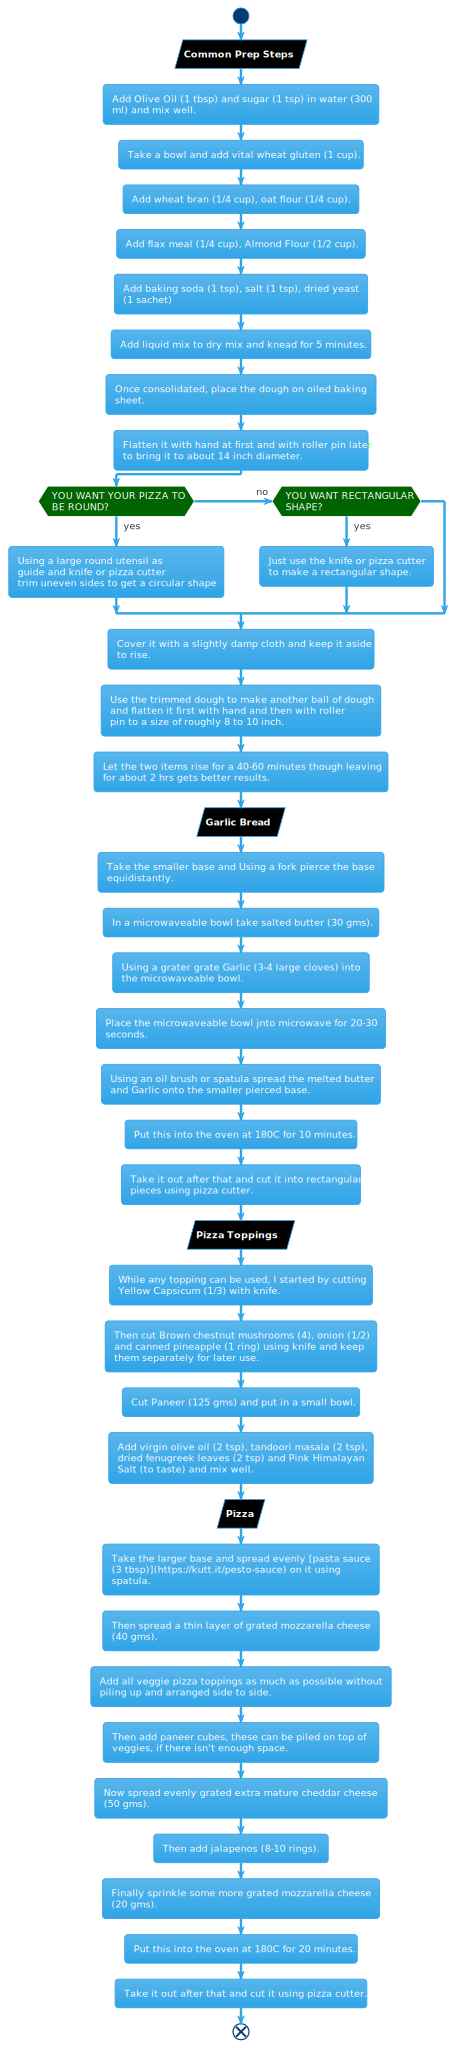

In [218]:
%%plantuml
@startuml
!theme cerulean

        <style>
        activityDiagram {
          diamond {
            BackgroundColor #darkgreen
            LineColor #white
            FontColor white
          }
        }
        </style>
    
start
#Black:**Common Prep Steps**/
:Add Olive Oil (1 tbsp) and sugar (1 tsp) in water (300
ml) and mix well.;
:Take a bowl and add vital wheat gluten (1 cup).;
:Add wheat bran (1/4 cup), oat flour (1/4 cup).;
:Add flax meal (1/4 cup), Almond Flour (1/2 cup).;
:Add baking soda (1 tsp), salt (1 tsp), dried yeast
(1 sachet);
:Add liquid mix to dry mix and knead for 5 minutes.;
:Once consolidated, place the dough on oiled baking
sheet.;
:Flatten it with hand at first and with roller pin later
to bring it to about 14 inch diameter.;
if (YOU WANT YOUR PIZZA TO
BE ROUND?) then (yes)
    :Using a large round utensil as
guide and knife or pizza cutter
trim uneven sides to get a circular shape;
(no) elseif (YOU WANT RECTANGULAR
SHAPE?) then (yes)
    :Just use the knife or pizza cutter
to make a rectangular shape.;
endif
:Cover it with a slightly damp cloth and keep it aside
to rise.;
:Use the trimmed dough to make another ball of dough
and flatten it first with hand and then with roller
pin to a size of roughly 8 to 10 inch.;
:Let the two items rise for a 40-60 minutes though leaving
for about 2 hrs gets better results.;
#Black:**Garlic Bread**/
:Take the smaller base and Using a fork pierce the base
equidistantly.;
:In a microwaveable bowl take salted butter (30 gms).;
:Using a grater grate Garlic (3-4 large cloves) into
the microwaveable bowl.;
:Place the microwaveable bowl jnto microwave for 20-30
seconds.;
:Using an oil brush or spatula spread the melted butter
and Garlic onto the smaller pierced base.;
:Put this into the oven at 180C for 10 minutes.;
:Take it out after that and cut it into rectangular
pieces using pizza cutter.;
#Black:**Pizza  Toppings**/
:While any topping can be used, I started by cutting
Yellow Capsicum (1/3) with knife.;
:Then cut Brown chestnut mushrooms (4), onion (1/2)
and canned pineapple (1 ring) using knife and keep
them separately for later use.;
:Cut Paneer (125 gms) and put in a small bowl.;
:Add virgin olive oil (2 tsp), tandoori masala (2 tsp),
dried fenugreek leaves (2 tsp) and Pink Himalayan
Salt (to taste) and mix well.;
#Black:**Pizza**/
:Take the larger base and spread evenly [pasta sauce
(3 tbsp)](https://kutt.it/pesto-sauce) on it using
spatula.;
:Then spread a thin layer of grated mozzarella cheese
(40 gms).;
:Add all veggie pizza toppings as much as possible without
piling up and arranged side to side.;
:Then add paneer cubes, these can be piled on top of
veggies, if there isn't enough space.;
:Now spread evenly grated extra mature cheddar cheese
(50 gms).;
:Then add jalapenos (8-10 rings).;
:Finally sprinkle some more grated mozzarella cheese
(20 gms).;
:Put this into the oven at 180C for 20 minutes.;
:Take it out after that and cut it using pizza cutter.;
end
@enduml